In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn import datasets

SEED=200
plt.ion()

# Implementar uma das duas funções abaixo:
## Reescalar entre 0 e 1 ou Normalização z-score

In [2]:
def rescale(df, columns, maximum=None, minimum=None):
    """
    df: dataframe com o dataset
    columns: nomes das colunas que devem ser reescaladas
    maximum: dicionário com os valores maximos, com cada chave representando uma coluna
    minimum: dicionário com os valores minimos, com cada chave representando uma coluna
    retorna o dataset reescalado
    """
    from copy import copy
    rescaledDF = copy(df)
    nmax,nmin = {},{}
    
    for c in columns:
        minc,maxc = min(df[c]),max(df[c])
        
        try:
            nmax[c]=maximum[c]
        except:
            nmax[c]=maxc
            
        try:
            nmin[c]=minimum[c]
        except:
            nmin[c]=minc
        
        rescaled = (df[c] - minc) * (nmax[c]-nmin[c]) / (maxc - minc) + nmin[c]
        rescaledDF[c] = rescaled
        
    return rescaledDF,nmax,nmin

def normalize(df, columns, mean=None, std=None):
    """
    df: dataframe com o dataset
    columns: nomes das colunas que devem ser normalizadas
    mean: dicionário com os valores médios, com cada chave representando uma coluna
    std: dicionário com os desvios padrão, com cada chave representando uma coluna
    retorna o dataset normalizado
    """
    raise NotImplementedError("implementar a função normalize")
    

# A célula seguinte carrega o dataset. Não é necessário modificar.

In [3]:
"""Load dataset"""
iris = datasets.load_iris()

df_full = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                       columns= iris['feature_names'] + ['target'])

def get_train_test_inds(y, train_proportion=0.7):
    """
    y: coluna do atributo alvo
    retorna os indices de treino e teste estratificados pela classe
    """
    y=np.array(y)
    train_inds = np.zeros(len(y),dtype=bool)
    test_inds = np.zeros(len(y),dtype=bool)
    values = np.unique(y)
    for value in values:
        value_inds = np.nonzero(y==value)[0]
        np.random.shuffle(value_inds)
        n = int(train_proportion*len(value_inds))

        train_inds[value_inds[:n]]=True
        test_inds[value_inds[n:]]=True

    return train_inds,test_inds


train_inds, test_inds = get_train_test_inds(df_full.loc[:, "target"])
df_full[['target']] = df_full[['target']].astype(int)
df = df_full[train_inds]
df_val = df_full[test_inds]

In [4]:
"""Use este trecho no caso de optar por reescalar"""
df, maximum, minimum = rescale(df, df.columns[0:4])
df_val, _, _ = rescale(df_val, df_val.columns[0:4], maximum, minimum)

# """Use este trecho no caso de optar por normalizar"""
# df, mean, std = normalize(df, df.columns[0:4])
# df_val, _, _ = normalize(df_val, df_val.columns[0:4], mean, std)

# Funções de Ativação e Softmax
## Implementar Relu, Sigmoid e Softmax

In [5]:
class Relu(object):
    def forward(self, x):
        """
        x: Entrada (batch_size, numero_de_neuronios)
        retorna a saída da ativação relu (batch_size, numero de neuronios)
        """
        r = []
        for xs in x:
            r.append(np.asarray(
                    [v if v > 0 else 0 for v in xs]
                ))
        
        return np.asarray(r)
#         raise NotImplementedError("implementar o relu")
    
    def backward(self, x):
        """
        x: Entrada no backward (batch_size, numero_de_neuronios)
        retorna a saída da derivada da ativação relu (batch_size, numero_de_neuronios)
        """
        r = []
        for xs in x:
            r.append(np.asarray(
                    [1 if v > 0 else 0 for v in xs]
                ))
        
        return np.asarray(r)
#         raise NotImplementedError("implementar o relu")

        
class Sigmoid(object):
    def sig(self,v):
        from math import e
        return 1/(1 + e**-v)
    
    def forward(self, x):
        """
        x: Entrada (batch_size, numero_de_neuronios)
        retorna a saída da ativação sigmoidal (batch_size, numero_de_neuronios)
        """
        r = []
        for xs in x:
            r.append(np.asarray(
                    [self.sig(v) for v in xs]
                ))
        
        return np.asarray(r)
#         raise NotImplementedError("implementar o sigmoid")
        
    def backward(self, x):
        """
        x: Entrada no backward (batch_size, numero_de_neuronios)
        retorna a saída da derivada da ativação sigmoidal (batch_size, numero_de_neuronios)
        """
        
        r = []
        for xs in x:
            r.append(np.asarray(
                    [(1-self.sig(v))*self.sig(v) if v > 0 else 0 for v in xs]
                ))
        
        return np.asarray(r)
#         raise NotImplementedError("implementar o sigmoid")
        

def softmax(x):
    """
    x: Entrada (batch_size, numero_de_neuronios)
    retorna a probabilidade de cada classe (batch_size, numero_de_neuronios)
    """
    from math import e
    
    r = []
    for xs in x:
        e_z = [e**v for v in xs]
        s = sum(e_z)
        r.append(np.asarray([v/s for v in e_z]))
    
    return np.asarray(r)
#     raise NotImplementedError("implementar o softmax")

# A célula seguinte implementa uma Rede Neural com 2 camadas escondidas. 

In [10]:
class NeuralNetwork(object):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size,
                 activation_fn='relu', learning_rate=1e-2, sigma=1., weight_decay=0.1):
        """Inicializacao pronta. Nao alterar"""
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.sigma = sigma
        
        # relu or sigmoid
        if activation_fn == 'relu':
            self.activation_fn = Relu()
        elif activation_fn == 'sigmoid':
            self.activation_fn = Sigmoid()
        
        # inicializa as matriz dos parametros
        self.params = {}
        self.params["w1"] = sigma * np.random.randn(input_size, hidden_size1)
        self.params["b1"] = np.zeros(hidden_size1)
        self.params["w2"] = sigma * np.random.randn(hidden_size1, hidden_size2)
        self.params["b2"] = np.zeros(hidden_size2)
        self.params["w3"] = sigma * np.random.randn(hidden_size2, output_size)
        self.params["b3"] = np.zeros(output_size)
        
        # inicializa as matrizes de gradientes
        self.grads = {}
        self.grads["w1"] = np.zeros((input_size, hidden_size1))
        self.grads["b1"] = np.zeros(hidden_size1)
        self.grads["w2"] = np.zeros((hidden_size1, hidden_size2))
        self.grads["b2"] = np.zeros(hidden_size2)
        self.grads["w3"] = np.zeros((hidden_size2, output_size))
        self.grads["b3"] = np.zeros(output_size)
        
    def forward(self, x):
        """
        x: entrada da rede neural
        retorna as probabilidades de cada classe (batch_size, numero_de_classes)
        """
        self.LAYERS = 3
        
        if len(x.shape) == 1:
            x = np.asarray([x])
        
        self.intermediate_results = [x]
        f = [self.activation_fn.forward,self.activation_fn.forward,softmax]
        
        for i in range(self.LAYERS):
            tmp = []
            w = self.params["w"+str(i+1)]
            b = self.params["b"+str(i+1)]
            for xs in self.intermediate_results[-1]:
                p = []
                for wj in range(w.shape[1]):
                    p.append(0)
                    for wi in range(w.shape[0]):
                        p[-1] += w[wi,wj] * xs[wi]
                    p[-1] += b[wj]
                tmp.append(p)
            self.intermediate_results.append(f[i](tmp))
        
        return self.intermediate_results[-1]
        
    def backward(self, y):
        """
        y: indices das classes esperadas (batch_size, 1)
        retorna o loss e o dicionario de gradientes
        """
        def cat_ce(ys,preds):
            from math import log
            def ce(yi,pred):
                if yi:
                    return -log(pred + 1e-15)
                return -log(1-pred + 1e-15)
            
            ac = sum([sum(map(lambda vi : 
                               ce(vi[0],vi[1]), zip(ys[i],preds[i])
                                ))
                          for i in range(len(ys))])
            return ac/len(ys)
            
        y_adj = []
        for i in y:
            a = np.zeros(self.output_size)
            
            if self.output_size == 1:
                a[0] = i
            else:
                a[i] = 1
            
            y_adj.append(a)
        
        loss = cat_ce(y_adj,self.intermediate_results[-1])
        
        last = np.asarray(self.intermediate_results[-1]) - np.asarray(y_adj)
        
        f = [self.activation_fn.backward,self.activation_fn.backward, lambda x : 1]
        
        adds = {}
        
        for i in range(self.LAYERS,0,-1):
            tmp = []
            current = f[i-1](np.asarray(self.intermediate_results[i]))
            last = last * current
            
            for col in range(self.grads["b"+str(i)].shape[0]):
                lT = last.transpose()
                lT = np.asarray(list(map(lambda x : x.mean(),lT)))
                assert self.grads["b"+str(i)].shape == lT.shape
                self.grads["b"+str(i)] = lT
            
            w = self.params["w"+str(i)]
            
            for xs, l in zip(self.intermediate_results[i-1],last): # for each batch
                tmp.append([])
                for wi in range(w.shape[0]):
                    p = []
                    xsi = xs[wi]
                    for j,v in enumerate(l):
                        try:
                            adds["%s|%s|%s" % (str(i),str(wi),str(j))] += xsi * v,1
                        except:
                            adds["%s|%s|%s" % (str(i),str(wi),str(j))] = np.asarray([xsi * v,1])
                        
                        p.append(w[wi,j] * v)
                    tmp[-1].append(np.asarray(sum(p)))
                    
                        
                tmp[-1] = np.asarray(tmp[-1])
            last = np.asarray(tmp[:])
        
        for k,v in adds.items():
            i,wi,j = list(map(int,k.split('|')))
            self.grads["w"+str(i)][wi,j] = self.weight_decay*v[0]/v[1]
        
        return loss,self.grads
#         raise NotImplementedError("implementar o backward")
        
    def optimize(self):
        """
        Faz um step do gradiente descendente, nao alterar
        """
        self.params["w3"] = self.params["w3"] - self.learning_rate*(self.grads['w3'])
        self.params["b3"] = self.params["b3"] - self.learning_rate*(self.grads['b3'])

        self.params["w2"] = self.params["w2"] - self.learning_rate*(self.grads['w2'])
        self.params["b2"] = self.params["b2"] - self.learning_rate*(self.grads['b2'])
        
        self.params["w1"] = self.params["w1"] - self.learning_rate*(self.grads['w1'])
        self.params["b1"] = self.params["b1"] - self.learning_rate*(self.grads['b1'])

# Devem ser alterados os hiperparâmetros para melhor otimização da rede
## Alguns dos hiperparâmetros que podem ser modificados estão na célula abaixo

In [7]:
learning_rate = 1e-3
activation_fn = 'relu'
weight_decay = 0.001 # lambda
epochs = 1000
batch_size = 10

In [11]:
classes = df.loc[:,"target"].unique() # numero de classes do dataset
classes.sort()

network = NeuralNetwork(df.shape[1]-1, 10, 10, output_size=len(classes), learning_rate=learning_rate,
                        activation_fn=activation_fn, weight_decay=weight_decay)

<IPython.core.display.Javascript object>


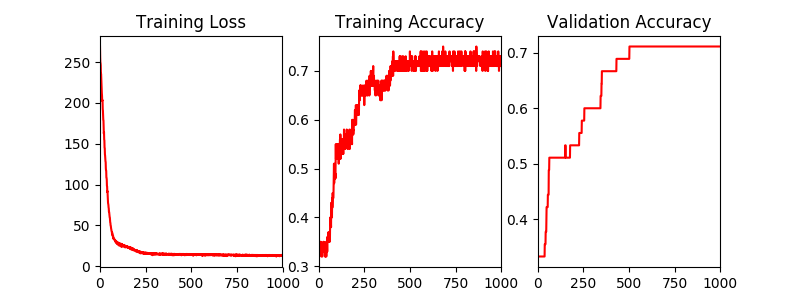

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [12]:
"""Nao alterar esta celula"""
# Cria o grafico e atualiza os pesos
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,3))
ax1.set_title('Training Loss')
ax2.set_title('Training Accuracy')
ax3.set_title('Validation Accuracy')

t = tqdm(range(epochs))
losses = []
training_accuracy = []
accuracy = []

# Visualizacao do treinamento
drawn, = ax1.plot(np.arange(0), losses, c='r')
drawn2, = ax2.plot(np.arange(0), training_accuracy, c='r')
drawn3, = ax3.plot(np.arange(0), accuracy, c='r')

# Loop de treinamento
for e in t:
    # aleatoriza o treino e zera estatisticas
    df = df.sample(frac=1., random_state=SEED)
    total_loss = 0
    correct = 0
    total = 0
    # Loop da epoca
    for i in range(0, df.shape[0]-batch_size, batch_size):
        total += batch_size
        batch = df.iloc[i:(i+batch_size), :]
        y = df.iloc[i:(i+batch_size)]
        y = y.loc[:, "target"]
        batch = batch.drop(["target"], axis=1)
        predictions = network.forward(batch.values)
        loss, grads = network.backward(y)
        total_loss += loss
        network.optimize()
        correct += sum(y.values == predictions.argmax(axis=1))
    
    # Atualiza estatisticas e graficos
    training_accuracy.append(correct/total)
    losses.append(total_loss)
    t.set_description('Loss: %.3f' % total_loss)
    drawn.set_data((np.arange(len(losses)), losses))
    ax1.relim()
    ax1.set_xlim((0, e))
    ax1.autoscale_view()
    
    drawn2.set_data((np.arange(len(training_accuracy)), training_accuracy))
    ax2.relim()
    ax2.set_xlim((0, e))
    ax2.autoscale_view()
    
    ### VALIDACAO ###
    batch = df_val
    y = df_val.loc[:, "target"]
    batch = batch.drop(["target"], axis=1)

    predictions = network.forward(batch.values)
    correct = np.sum(y.values == predictions.argmax(axis=1))
    accuracy.append(correct/df_val.shape[0])
    
    # Atualiza grafico de validacao
    drawn3.set_data((np.arange(len(accuracy)), accuracy))
    ax3.relim()
    ax3.set_xlim((0, e))
    ax3.autoscale_view()
    fig.canvas.draw()